# Title: Heart Disease .....

### *Introduction*
- ...
- Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
- Clearly state the question you will try to answer with your project
- Identify and describe the dataset that will be used to answer the question

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [5]:
set.seed(3456)
url <- "https://raw.githubusercontent.com/jenpari3/Heart_Group_Proposal/main/heart_disease_uci.csv"
heart_data <- read_csv(url)
heart_data

Rows: 920 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): sex, dataset, cp, restecg, slope, thal
dbl (8): id, age, trestbps, chol, thalch, oldpeak, ca, num
lgl (2): fbs, exang

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,63,Male,Cleveland,typical angina,145,233,TRUE,lv hypertrophy,150,FALSE,2.3,downsloping,0,fixed defect,0
2,67,Male,Cleveland,asymptomatic,160,286,FALSE,lv hypertrophy,108,TRUE,1.5,flat,3,normal,2
3,67,Male,Cleveland,asymptomatic,120,229,FALSE,lv hypertrophy,129,TRUE,2.6,flat,2,reversable defect,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
918,55,Male,VA Long Beach,asymptomatic,122,223,TRUE,st-t abnormality,100,FALSE,0,NA,NA,fixed defect,2
919,58,Male,VA Long Beach,asymptomatic,NA,385,TRUE,lv hypertrophy,NA,NA,NA,NA,NA,NA,0
920,62,Male,VA Long Beach,atypical angina,120,254,FALSE,lv hypertrophy,93,TRUE,0,NA,NA,NA,1


In [12]:
# select the columns that we want to use
heart_data_wrangled <- select(heart_data, age, dataset, trestbps, chol, num) |>
    filter(dataset == "Cleveland")
heart_data_wrangled

age,dataset,trestbps,chol,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
63,Cleveland,145,233,0
67,Cleveland,160,286,2
67,Cleveland,120,229,1
⋮,⋮,⋮,⋮,⋮
57,Cleveland,130,236,1
38,Cleveland,138,175,0
28,Cleveland,130,132,0


#### *Explanation to Why These Columns are Selected*
- We selected these columns because

#### *What do you expect to find?*

### *Preliminary exploratory data analysis*

In [13]:
#training data
heart_data_split <- initial_split(heart_data_wrangled, prop = 0.75, strata = num)
heart_data_training <- training(heart_data_split)
heart_data_training

age,dataset,trestbps,chol,num
<dbl>,<chr>,<dbl>,<dbl>,<dbl>
63,Cleveland,145,233,0
41,Cleveland,130,204,0
56,Cleveland,120,236,0
⋮,⋮,⋮,⋮,⋮
58,Cleveland,136,319,3
55,Cleveland,128,205,3
59,Cleveland,164,176,3


In [18]:
# mean of selected predictors
heart_data_mean <- summarize(heart_data_training, 
                             age_mean = mean(age),
                             chol_mean = mean(chol), 
                             trestbps_mean = mean(trestbps)) |>
                    pivot_longer(cols = age_mean:trestbps_mean,
                                 names_to = "variables",
                                 values_to = "mean")
heart_data_mean

# number of observations for each class
heart_data_observations <- group_by(heart_data_training, num) |>
    summarize(count = n())
heart_data_observations

# rows with missing data
heart_data_missing <- filter(heart_data_training, is.na(trestbps) & is.na(chol) & is.na(num)) |>
    count()
heart_data_missing


variables,mean
<chr>,<dbl>
age_mean,54.49339
chol_mean,246.04846
trestbps_mean,131.75330


num,count
<dbl>,<int>
0,123
1,41
2,27
3,26
4,10


n
<int>
0


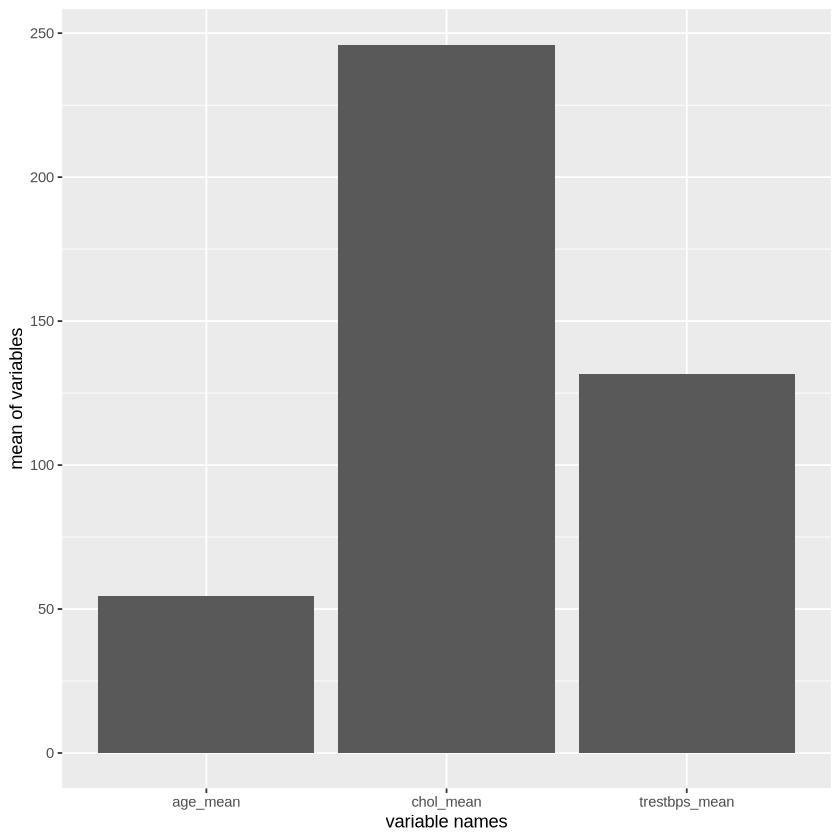

In [21]:
#graph for mean data
heart_data_mean_plot <- heart_data_mean |>
    ggplot(aes(x = variables, y = mean)) +
    geom_bar(stat = "identity") +
    labs(x = "variable names", y = "mean of variables")
heart_data_mean_plot

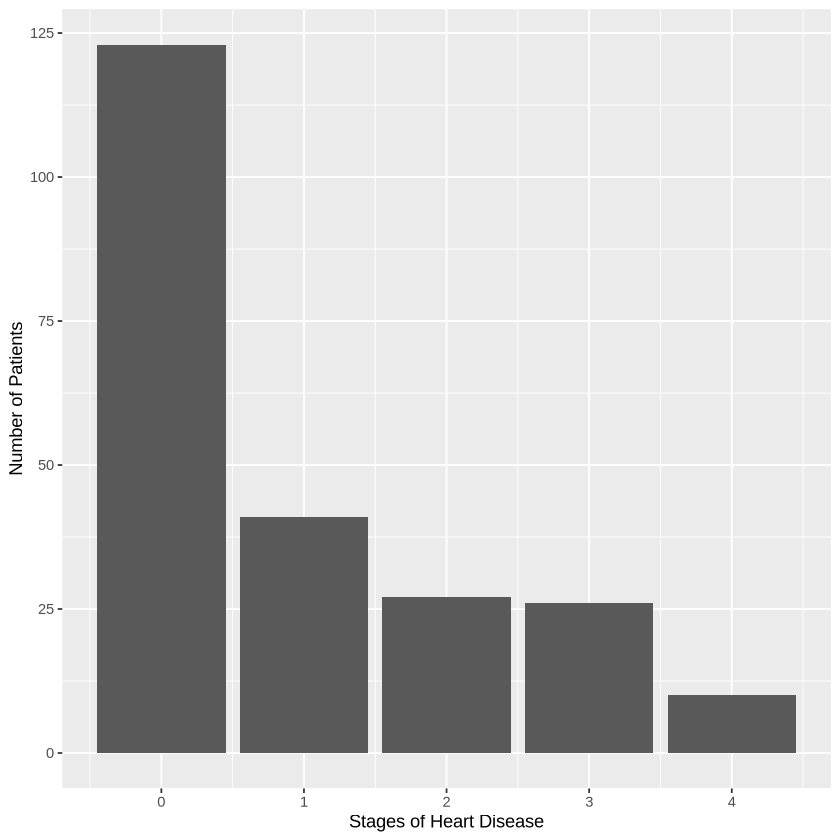

In [22]:
#graph for number of observations
heart_data_observation_plot <- heart_data_observations |>
    ggplot(aes(x = num, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Stages of Heart Disease", y = "Number of Patients")
heart_data_observation_plot

In [ ]:
# scaling data
#heart_data_scaled <- heart_data_training |> 
#mutate(scaled_trestbps = scale(trestbps, center = TRUE), 
#        scaled_chol = scale(chol, center = TRUE))
#heart_data_scaled

In [2]:
# Data Visualization
#heart_visual <- heart_data_scaled |>
#    ggplot(aes(x = scaled_trestbps, y = scaled_chol, colour = target)) +
#    geom_point() +
#    labs(x = "Rest Blood Pressure (mm Hg)", y = "Serum Cholestoral (mg/dl)")
#heart_visual

### *Methods*

### *Expected outcomes and significance*

- What impacts could such findings have?
- What future questions could this lead to?